In [1]:
import numpy as np
import scipy.io as sio
from scipy.ndimage import gaussian_filter
from skimage import filters
#from skimage.filters import threshold_multiotsu
import sys
import cv2
from skimage.filters import threshold_otsu, threshold_multiotsu
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import spdiags
from scipy.sparse import linalg
from scipy.sparse import csc_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
#!{sys.executable} -m pip install -U scikit-image==0.17.2 --user

In [26]:
def ConvexSeg_Run(output,z,c1,c2,lambda1,tau,Iters,utol,theta,sigma1,CV_type,lambda3,eps2,w,lambda_TV,theta_tai):

    [m,n] = np.shape(z);

    ## FLAG KEY 
    # 0 - Spencer-Chen
    # 1 - Geodesic

    LOAD = sio.loadmat('TestFilesPython.mat')

    for flag in [1]:

        if theta == 0 or lambda1 == 0:
            SSF = np.zeros(np.shape(z));
            u = z.copy();

        else:

            if flag == 0:
                
                #figure;imagesc(z);colormap(gray) % Me
                #[Mask,cols,rows] = roipoly;
                #close
                
                # TODO: Code interface for input a binary mask
                print('FLAG = 0')
                #Mask = imdilate(Mask,strel('disk',3));
                #SSF = theta *Pd(Mask>0.5); % fitting terms
                
            elif flag ==1:

                #[Pd1,cols,rows,R_min,R_max,C_min,C_max,z] = Geo_MarkerAndAntimarker( z );
                Pd1 = np.array(LOAD['Pd1'])
                cols = np.array(LOAD['cols'])
                rows = np.array(LOAD['rows'])
                R_min = np.array(LOAD['R_min'])
                R_max = np.array(LOAD['R_max'])
                C_min = np.array(LOAD['C_min'])
                C_max = np.array(LOAD['C_max'])
                z = np.array(LOAD['z'])
                n, m = np.shape(z);
                #C = convhull(rows,cols);
                C = np.array(LOAD['C'])
                #Mask = roipoly(Pd1,cols(C),rows(C));
                Mask = np.array(LOAD['Mask'])
                SSF = theta * Pd1/np.max(Pd1.flatten());
                
                # TODO: Code geodesic distance calculator

            u = Mask.copy();

            if np.shape(cols)[0]*np.shape(cols)[1] == 1 and np.shape(rows)[0]*np.shape(rows)[1] == 1:
                Mask[rows:rows+2,cols:cols+2] = 1


        #### Additional parameters
        mu = 1; # regularisation term
        varsigma = 1e-2; # parameter in penalty function
        as1 = 2; # multiply minimum alpha value by as1
        beta = eps2; # parameter in curvature
        b = 161.7127690; # from Taylor expansion of fpen fn.

        sig = np.maximum(1.0,np.sqrt(100.0*sigma1))
        z_sm = gaussian_filter(z, sigma=sig)
        
        gx,gy = np.gradient(z_sm);
        nab_z = np.sqrt(gx**2+gy**2);
        beta1 = 10;
        g = 1 / (1+ beta1*nab_z**2);

        #### For recording progression of residual
        res = [];
        #### Calculate fitting term and set alpha

        c1 = np.sum(z[Mask>0.5])/np.sum(Mask>0.5)
        c2 = np.sum(z[Mask<0.5])/np.sum(Mask<0.5)
        
        print(c1,c2)
        
        if CV_type == 0: # Original Chan-Vese

            f1 = (z-c1)**2-lambda3 *(z-c2)**2 + SSF;

        elif CV_type==1: # Roberts-Spencer

            N = 3;
            
            K11 = np.expand_dims(np.array(threshold_multiotsu(z,classes = N)),0)
            K = np.concatenate((np.zeros((1,1)),K11),1)
            K = np.concatenate((K,np.ones((1,1))),1)[0]
            
            # LOWER THRESHOLD
            L_vect = np.maximum(c1 - K,0.0)
            L_vect2 = L_vect.copy()
            TF_vect = np.expand_dims(np.arange(np.shape(L_vect)[0]),0)[0]
            TF_vect = TF_vect[L_vect>0.0]
            L_vect2 = L_vect2[L_vect>0.0]      
            TF2 = np.where(L_vect2==np.min(L_vect2))[0][0]
            L = K[TF_vect[TF2]]

            # UPPER THRESHOLD
            H_vect = np.maximum(K - c1,0.0)
            H_vect2 = H_vect.copy()
            
            TF_vect = np.expand_dims(np.arange(np.shape(L_vect)[0]),0)[0]
            TF_vect = TF_vect[H_vect>0.0]
            H_vect2 = H_vect2[H_vect>0.0]
                                     
            if not H_vect2.all():
                H = K[-1];
            else:
                TF2 = np.where(H_vect2==np.min(H_vect2))[0]
                H = K[TF_vect[TF2[0]]];
            
            gamma1 = c1 - L;
            gamma2 = H - c1;

            TF3 = np.logical_and(z>=c1-gamma1, z<=c1)
            TF4 = np.logical_and(z<=c1+gamma2, z>c1)

            f3 = ( 1+((z-c1)/gamma1) )*TF3 + ( 1-((z-c1)/gamma2) )*TF4 

            f1 = ((z-c1)**2) - lambda3 * f3 + SSF ;     

        #elseif (CV_type==2) % Inhom-Roberts-Spencer
        #    f3 = RS_Inhom(z,Mask);
        #    f1 = ((z-c1).^2) - lambda3 * f3 + SSF ;

        print('outer = 1 -- c1 = '+str(np.round(c1,3))+', c2 = '+str(np.round(c2,3))+', do '+str(Iters)+' Iterations: ____')
        
        
        for l in range(Iters):

            if (l+1) % 50 == 0:
                tau = np.maximum(1.0e-3,tau*0.9);
        

            if l % 2 ==0:

                if CV_type==1: # Roberts-Spencer

                    # LOWER THRESHOLD
                    L_vect = np.maximum(c1 - K,0.0)
                    L_vect2 = L_vect.copy()
                    TF_vect = np.expand_dims(np.arange(np.shape(L_vect)[0]),0)[0]
                    TF_vect = TF_vect[L_vect>0.0]
                    L_vect2 = L_vect2[L_vect>0.0]      
                    TF2 = np.where(L_vect2==np.min(L_vect2))[0][0]
                    L = K[TF_vect[TF2]]

                    # UPPER THRESHOLD
                    H_vect = np.maximum(K - c1,0.0)
                    H_vect2 = H_vect.copy()

                    TF_vect = np.expand_dims(np.arange(np.shape(L_vect)[0]),0)[0]
                    TF_vect = TF_vect[H_vect>0.0]
                    H_vect2 = H_vect2[H_vect>0.0]

                    if not H_vect2.all():
                        H = K[-1];
                    else:
                        TF2 = np.where(H_vect2==np.min(H_vect2))[0]
                        H = K[TF_vect[TF2[0]]];

                    gamma1 = c1 - L;
                    gamma2 = H - c1;

                    TF3 = np.logical_and(z>=c1-gamma1, z<=c1)
                    TF4 = np.logical_and(z<=c1+gamma2, z>c1)

                    f3 = ( 1+((z-c1)/gamma1) )*TF3 + ( 1-((z-c1)/gamma2) )*TF4 

                    f1 = ((z-c1)**2) - lambda3 * f3 + SSF ; 


            #if rem(l,50)==0
            #    figure(1);
            #    subplot(121);imagesc(z);colormap(gray);hold on; contour(u,[0.5 0.5],'r','LineWidth',2);drawnow
            #    subplot(122);surf(u);drawnow
            #end

            oldu = u.copy()

            f0 = lambda1*f1/np.max(f1.flatten());
            f11 = f0.flatten();
            A = (1/2) * LA.norm(f11, np.inf) # minimum for alpha from Chan paper
            alpha = as1*A;

            #### Calculate penalty term
            N1 = np.sqrt((2*u-1)**2+varsigma)-1;
            Hnu = (1/2)+(1/np.pi)*np.arctan(N1/varsigma);
            dN_num1 = np.divide((4*u-2.0),(N1+1.0)) 
            dN = dN_num1 * (np.divide(varsigma*N1,np.pi*(varsigma**2+N1**2))+ Hnu)
            dNu = alpha*dN;
        
            #### Perform AOS iteration
            #### v2 is from CMS 15 paper
            u = AOS_v2(u,n,g,tau,mu,f0,beta,dNu,b,alpha,varsigma,theta_tai);

            #### Check residual and store
            R = Residual(u,oldu)
            res.append(R)

            if l % 50 ==0:
                print('It:'+str(l)+', Res:'+str(np.round(R,3)))
            

            #### Stopping criterion for u
            if R < utol:
                break

        print(' == Done ('+str(l+1)+' iters) \n')

        Res_Final = res;
        Iters_Final = l
        TC = 1
        u_data = u

    return u #TC,Iters_Final,Res_Final,u,cols,rows,u_data,R_min,R_max,C_min,C_max


def Residual(new,old):

    n,m = np.shape(new);
    Res = new.flatten() - old.flatten();
    R = LA.norm(Res)/LA.norm(old.flatten());

    return R

def normalize0a(z,a):
    # Normalize to the range of [0,1]
    fmin  = np.min(z.flatten());
    fmax  = np.max(z.flatten());
    z = (z-fmin)/(fmax-fmin);
    z = a*z;
    return z


def AOS_v2(u,n,g,tau,mu,f,beta,dNu,b,alpha,varsigma,theta_tai):
    ####### CMS Spencer, Chen AOS2 %%%%%%%%%%

    h = 1; m = n; N = m*n;
    
    if np.sum(u.flatten())==0:
        print('Broken! All Zero')
        return

    btaylor = np.zeros((n,n));
    
    T1 = np.logical_and(u<=varsigma,u>=-varsigma)
    T2 = np.logical_and(u<=1+varsigma,u>=1-varsigma)
    btaylor = np.logical_or(T1,T2).astype(np.int32)*b
    
    diags = np.array([0])
    ON = sparse.eye(N)
    
    bvecx = btaylor.flatten()
    taybx = spdiags(bvecx, diags, N, N)
    bvecy = np.transpose(btaylor).flatten()
    tayby = spdiags(bvecy, diags, N, N) 

    A1 = 1.0/(1.0+tau*alpha*bvecx)
    Bx = spdiags(A1, diags, N, N)  #ON + tau*alpha*tayby

    A2 = 1.0/(1.0+tau*alpha*bvecy)
    By = spdiags(A2, diags, N, N)  #ON + tau*alpha*tayby
    
    
    R0 = -tau*f - tau*dNu
    Rx = np.multiply(A1,R0.flatten()) #np.multiply(csr_matrix(Bx),R0)
    Ry = np.multiply(A2,np.transpose(R0).flatten()) #np.multiply(csr_matrix(Bx),R0)
    
    R_x = Rx.flatten();
    R_y = Ry.flatten();
    
    #ux = diff(u);
    #uy = diff(u')';
    #ux = [ux;zeros(1,m)];
    #uy = [uy zeros(n,1)];
    ux , uy = np.gradient(u)

    ucx = u[2:,:]-u[:n-2,:];
    U11 = np.expand_dims(u[1,:]-u[0,:],0)
    U12 = np.expand_dims(u[-1,:]-u[-2,:],0)
    ucx = np.concatenate((U11,ucx),0)
    ucx = np.concatenate((ucx,U12),0)
    
    ucy = u[:,2:]-u[:,:m-2]
    U11 = np.expand_dims(u[:,1]-u[:,0],1)
    U12 = np.expand_dims(u[:,-1]-u[:,-2],1)
    
    ucy = np.concatenate((U11,ucy),1)
    ucy = np.concatenate((ucy,U12),1)
    
    d1 = np.divide(1.0,np.sqrt((ux/h)**2+(ucy/(2*h))**2+beta))
    d2 = np.divide(1.0,np.sqrt((ucx/(2*h))**2+(uy/h)**2+beta))
    
    d11 = g*d1;
    a1 = np.zeros((N,1))
    a2 = np.zeros((N,1))
    a3 = np.zeros((N,1))
    
    for j in range(m):
        j0 = j*n;
        d_1 = np.expand_dims(d11[:n-1,j],1);
        a1[j0:n-1+j0] = +d_1;
        a3[1+j0:n+j0] = +d_1;
        a2[j0:n-1+j0] = -d_1;
        a2[1+j0:n+j0] = a2[1+j0:n+j0] - d_1;

    AA11 = np.concatenate((np.transpose(a1),np.transpose(a2)),0)
    AA11 = np.concatenate((AA11,np.transpose(a3)),0)

    Ax = spdiags(AA11,np.array([-1,0,1]),N,N)
    A1 = sparse.eye(N)*(1.0-tau*theta_tai) - Bx*(2.0*tau*mu*Ax);

    u_1 = (R_x+u.flatten()).astype(np.float32)
    u1 = spsolve(A1,u_1)
    u1 = u1.reshape((n,m))
    
    d22 = g*d2;
    b1 = np.zeros((N,1))
    b2 = np.zeros((N,1))
    b3 = np.zeros((N,1))
    for i in range(n):
        i0 = i*m;
        d_2 = np.expand_dims(d22[i,:m-1],1);
        b1[i0:m-1+i0] = +d_2;
        b3[1+i0:m+i0] = +d_2;
        b2[i0:m-1+i0] = -d_2;
        b2[1+i0:m+i0] = b2[1+i0:n+i0] - d_2;
        
    AA11 = np.concatenate((np.transpose(b1),np.transpose(b2)),0)
    AA11 = np.concatenate((AA11,np.transpose(b3)),0)
    
    Ay = spdiags(AA11,np.array([-1,0,1]),N,N)
    A2 = sparse.eye(N)*(1.0-tau*theta_tai) - By*(2.0*tau*mu*Ay);
    
    u_2 = (R_y+np.transpose(u).flatten()).astype(np.float32)
    u2 = spsolve(A2,u_2)
    u2 = u2.reshape((m,n))
    u2 = np.transpose(u2)
    
    #u = u2
    u = (u1+u2)/2
            
    return u


In [44]:
LOAD = sio.loadmat('TestFilesPython.mat')
z = np.array(LOAD['z'])
c1 = 0
c2 = 1
lambda1 = np.array(LOAD['lambda'])[0][0]
tau = np.array(LOAD['tau'])[0][0]
Iters = np.array(LOAD['Iters'])[0][0]
utol = np.array(LOAD['utol'])[0][0]
theta = np.array(LOAD['theta'])[0][0]/2
sigma1 = np.array(LOAD['sigma1'])[0][0]
CV_type = np.array(LOAD['CV_type'])[0][0]
lambda3 = np.array(LOAD['lambda3'])[0][0]
eps2 = np.array(LOAD['eps2'])[0][0]
w = np.array(LOAD['w'])
lambda_TV = np.array(LOAD['lambda_TV'])[0][0]
theta_tai = np.array(LOAD['theta_tai'])[0][0]

Iters = 500

U = ConvexSeg_Run(518,z,c1,c2,lambda1,tau,Iters,utol,theta,sigma1,CV_type,lambda3,eps2,w,lambda_TV,theta_tai)




0.24792534577570405 0.6114759869704477
outer = 1 -- c1 = 0.248, c2 = 0.611, do 500 Iterations: ____
It:0, Res:0.231
It:50, Res:0.013
It:100, Res:0.007
It:150, Res:0.004
It:200, Res:0.002
It:250, Res:0.002
It:300, Res:0.002
It:350, Res:0.001
It:400, Res:0.001
It:450, Res:0.001
 == Done (500 iters) 



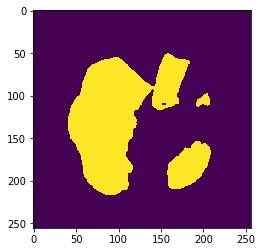

In [45]:
plt.imshow(U>0.1)

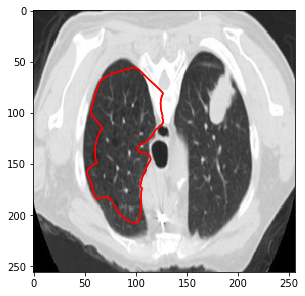

In [47]:
fig1, ax2 = plt.subplots(constrained_layout=True)
ax2.imshow(z,cmap='gray')
origin = 'lower'
CS2 = ax2.contour(U, levels=[0.5000,0.50001], colors='r', origin=origin)